<a href="https://colab.research.google.com/github/Manisha2297/RestroRecommender/blob/main/YelpRestroRecommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RestroRecommender
> Helping you discover the best restaurants

<p><img src="https://cdn.app.compendium.com/uploads/user/8cae7864-8129-4f90-831f-58f1a01c3e5e/60b3624a-ca2d-4418-ac2b-a3997bb708a0/File/a588145e33ec434b6bfd3ceffd5668ac/gettyimages_171115963.jpg" width="1500" height="600"></a><br><a href="https://www.incimages.com/uploaded_files/image/1920x1080/audience-pano_22824.jpg">Image Source</a></p>

# Introduction 

In this project we are building a recommender system that helps you choose the perfect restaurant based on your mood. Feel like having thai food tonight? Or feeling like dancing your heart out along with perfect meal? RestroRecommender has the relevent recommendations for you. 

Team - 
[Akshay Ranjith](https://github.com/akshaypt7), 
[Vishal Balaji](https://www.linkedin.com/in/vishal-balaji-121b49137/),
[Manisha R](https://github.com/Manisha2297), 
[Padmaja Bhagwat](https://www.linkedin.com/in/padmajavb/?)

# Data description

Here we've used [Yelp Dataset Challenge](https://www.yelp.com/dataset/documentation/main) and have only used restaurant data to train our model.    

The dataset consists of 2,09,393 different bussiness IDs out of which we are only considering those businesses that are **open** (1,68,903). 

This dataset contains business belonging to 2506 different categories, out of which we are only interested in categories that describe a restaurant viz. 'Restaurants','Food','Fast Food', 'Sandwiches','Burgers', 'Pizza', 'Breakfast & Brunch', 'Speciality Food', 'Mexican','Italian'

## Note
Since the data is huge, we have done all the preprocessing in chunks and have stored the final version of CSV/dataframes as a pickle file on the drive. 

Kindly add the shortcut to [this drive folder](https://drive.google.com/drive/folders/1TSbWcosRdVcBU6MUMAYKlQmiETWlQFTo?usp=sharing) on your drive before running the code. Here we've commented out the code that takes huge processing time and are directly loading the pickle files.

# Pre processing of data

#### Installing and Importing required libraries

In [ ]:
#mount your own drive to avoid downloading the data multiple time 
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install pickle5
!pip install surprise

     |████████████████████████████████| 133kB 17.8MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219247 sha256=5f0c3581e75b4533eafdaa9dc58fe004aaa2bcaaab23c44b2ab57c9a4e70ce07
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5
     |████████████████████████████████| 11.8MB 27.8MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617540 sha256=ca5bef506852703c2cbd1451929cb27b64268646c647dd6e84ba1430c8d1a2dc
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [ ]:
import numpy as np
import pandas as pd
import scipy as sp #imports stats functions, amongst other things
from scipy import stats 
from datetime import datetime

import matplotlib as mpl # this actually imports matplotlib
import matplotlib.cm as cm #allows us easy access to colormaps
import matplotlib.pyplot as plt #sets up plotting under plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack
from ast import literal_eval

from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split
from surprise.prediction_algorithms import Prediction
import random
from surprise.model_selection import GridSearchCV
from surprise.prediction_algorithms import algo_base
from surprise import NormalPredictor
from surprise import BaselineOnly

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Embedding, Add, Dot, Flatten
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation
from tensorflow.keras import backend as K

import pickle5 as pickle

from math import sin, cos, sqrt, atan2, radians

#### Converting large json files to CSV

Here we're loading the json file in chunks and converting it into CSV inorder to avoid running into memory error

In [ ]:
def json_to_csv(filepath, result_filepath):
  max_records = 1e5
  data = pd.read_json(filepath, lines=True,  chunksize=max_records)
  filtered_data = pd.DataFrame() # Initialize the dataframe
  try:
    for df_chunk in data:
        filtered_data = pd.concat([filtered_data, df_chunk])
  except ValueError:
        print ('\nSome messages in the file cannot be parsed')

  filtered_data.to_csv(result_filepath)

Uncomment the below lines to convert json files into CSV

In [ ]:
# json_to_csv("/content/gdrive/MyDrive/YelpDataset/yelp_academic_dataset_business.json", "/content/gdrive/MyDrive/YelpDataset/CsvFiles/yelp_academic_dataset_business.csv")
# json_to_csv("/content/gdrive/MyDrive/YelpDataset/yelp_academic_dataset_user.json", "/content/gdrive/MyDrive/YelpDataset/CsvFiles/yelp_academic_dataset_user.csv")
# json_to_csv("/content/gdrive/MyDrive/YelpDataset/yelp_academic_dataset_review.json", "/content/gdrive/MyDrive/YelpDataset/CsvFiles/yelp_academic_dataset_review.csv")

# EDA

In [ ]:
df_business = pd.read_csv('/content/gdrive/MyDrive/YelpDataset/CsvFiles/yelp_academic_dataset_business.csv')

In [ ]:
df_business.drop('Unnamed: 0',axis=1,inplace = True)
df_business.categories = df_business.categories.fillna('')

In [ ]:
df_business.is_open.value_counts()

1    168903
0     40490
Name: is_open, dtype: int64

#### Select the restaurants that are open

In [ ]:
df_open = df_business[df_business.is_open ==1]

### Plot the top 50 categories

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


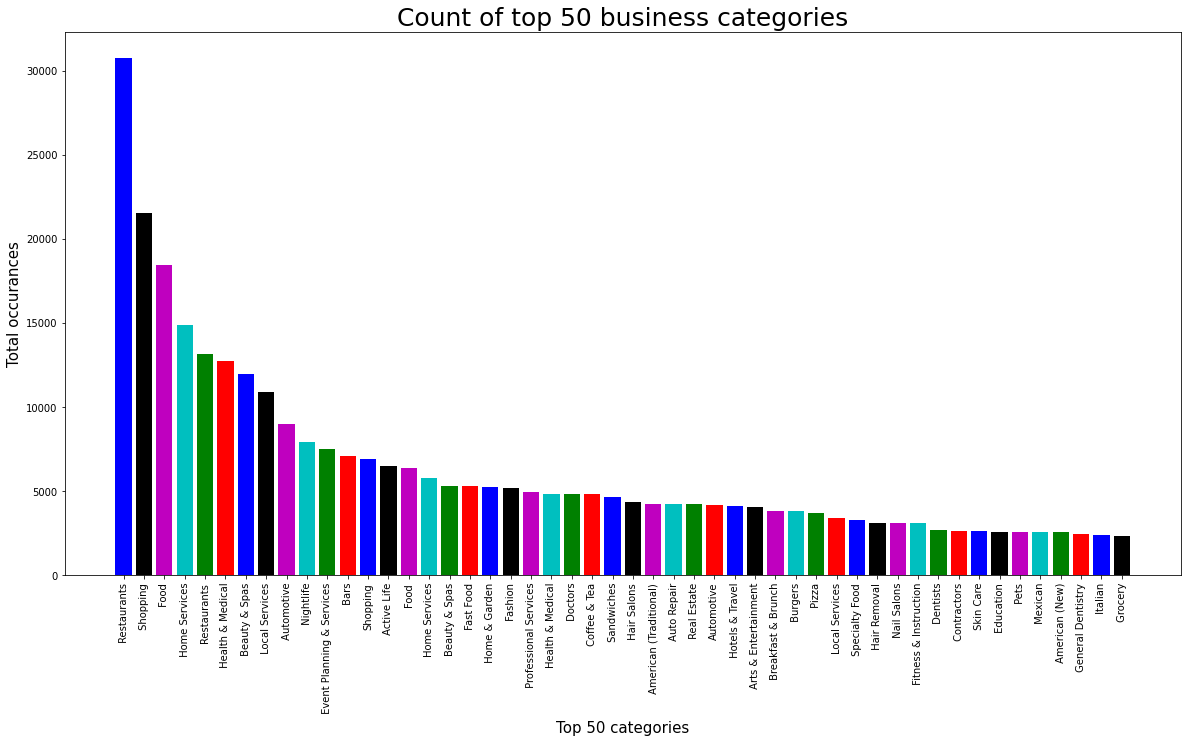

In [ ]:
# Plot below shows that restaurants and food are two of the biggest categories and this data also contain details of business that are not restaurants

categories = {}

for x in df_open.categories:
   all_categories = x.split(',')
   for cat in all_categories:
     if cat not in categories:
       categories[cat]=1
     else:
       categories[cat] +=1

category_keys = list(categories.keys())    
cat_list = [[x, categories[x]] for x in category_keys]

# print(sorted(cat_list, key = lambda x: x[1], reverse = True))

cat_list = sorted(cat_list, key = lambda x: x[1], reverse = True)   

top_50 = cat_list[:50]

plt.figure(figsize= (20,10))
plt.bar(range(len(top_50)), [x[1] for x in top_50],align = 'center',color ='bkmcgr' )
plt.xticks(range(len(top_50)), [x[0] for x in top_50], rotation = 'vertical')
plt.xlabel("Top 50 categories", size=15)
plt.ylabel("Total occurances", size=15)
plt.title("Count of top 50 business categories", size=25)
plt.show();

Here we see that the dataset contains all kind of businesses, we are only interested in thee categories that belong to restaurant.
Therefore we're selecting the rows that contain any one of the following categories from the above top 50 categories - ['Restaurants','Food','Fast Food', 'Sandwiches','Burgers', 'Pizza', 'Breakfast & Brunch', 'Speciality Food', 'Mexican','Italian']  

In [ ]:
def get_restaurantdf(resturant_keywords, df,restuarant_df, column_name):
  for index, row in df.iterrows():
    if any(key_word in row[column_name] for key_word in resturant_keywords):
      restuarant_df= pd.concat([restuarant_df,row])
  return restuarant_df

In [ ]:
restaurant_keywords= ['Restaurants','Food','Fast Food', 'Sandwiches','Burgers', 'Pizza', 'Breakfast & Brunch', 'Speciality Food', 'Mexican','Italian']

**Note** - Below cell takes a while to run. We've already processed the data and saved it as a pickle file. 

Uncomment the below cell to filter the business IDs based on the restaurant_keywords 

In [ ]:
# restaurant_df = get_restaurantdf(restaurant_keywords, df_open,pd.DataFrame(),'categories')
# row_size = int(len(restaurant_df)/14)
# restaurant_df = pd.DataFrame(restaurant_df.values.reshape((row_size,14)), columns=df_open.columns)

**Note:**

You need to run the above cell inorder to reproduce the below plots

[Text(0, 0.5, 'Total Number of Restaurants')]

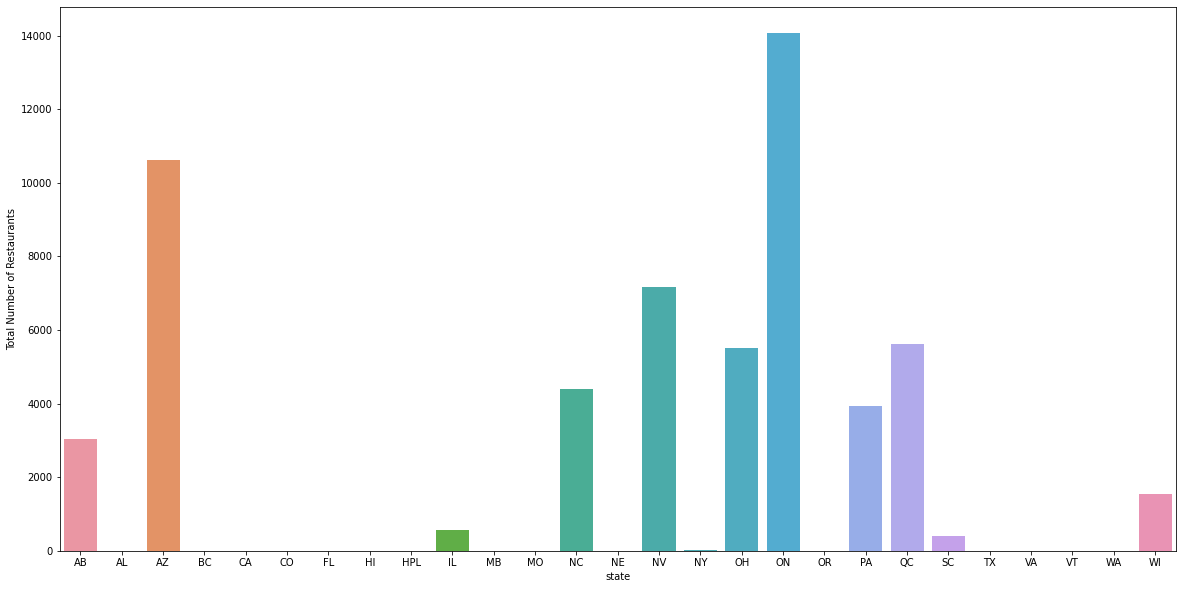

In [ ]:
plt.figure(figsize= (20,10)) # In log
df_res_per_state =  restaurant_df.groupby(['state'])['business_id'].count().reset_index()

ax = sns.barplot(x='state', y = 'business_id', data= df_res_per_state) # log
ax.set(ylabel= 'Total Number of Restaurants')

From the above plot we can see that there are only 11 states which have more than 50 restaurants, we will be considering only these states for our analysis.

### Slecting states with > 50 restaurants

In [ ]:
state_list = ['IL', 'WI', 'NC', 'ON', 'QC', 'AZ', 'OH', 'PA', 'AB', 'NV', 'SC']
restaurant_df = restaurant_df[restaurant_df['state'].isin(state_list)]

In [ ]:
# restaurant_df.to_pickle("/content/gdrive/MyDrive/YelpDataset/PickleFiles/restuarant_df")
# del restaurant_df

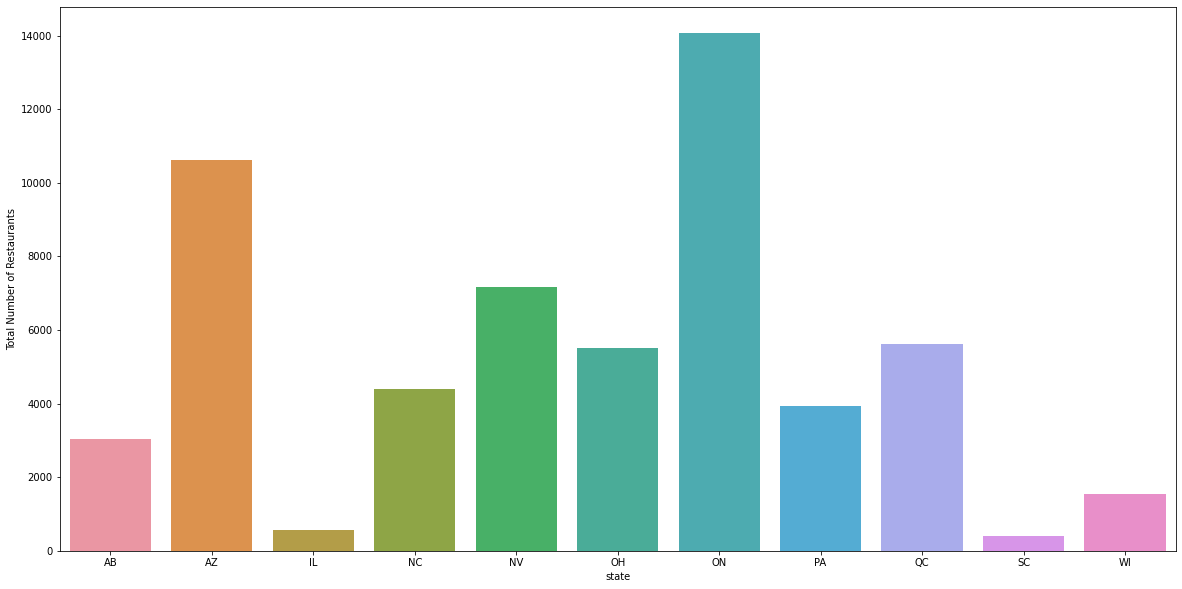

In [ ]:
plt.figure(figsize= (20,10)) 
df_res_per_state =  restaurant_df.groupby(['state'])['business_id'].count().reset_index()

ax = sns.barplot(x='state', y = 'business_id', data= df_res_per_state)
ax.set(ylabel= 'Total Number of Restaurants')
plt.show()

[Text(0, 0.5, 'Total Number of Restaurants')]

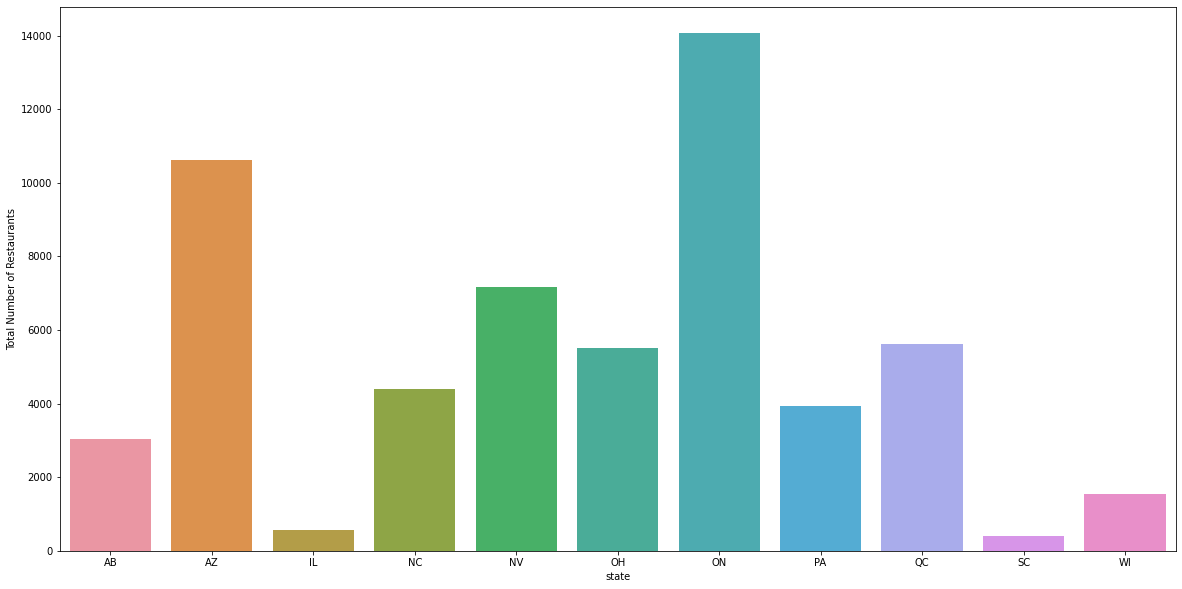

In [ ]:
plt.figure(figsize= (20,10)) # In log
df_res_per_state =  df_restaurant.groupby(['state'])['business_id'].count().reset_index()

ax = sns.barplot(x='state', y = 'business_id', data= df_res_per_state) 
ax.set(ylabel= 'Total Number of Restaurants')

In [ ]:
df_restaurant = pd.read_pickle("/content/gdrive/MyDrive/YelpDataset/PickleFiles/restuarant_df")

In [ ]:
df_restaurant.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,404 E Green St,"{'RestaurantsAttire': ""u'casual'"", 'Restaurant...",pQeaRpvuhoEqudo3uymHIQ,"Ethnic Food, Food Trucks, Specialty Food, Impo...",Champaign,"{'Monday': '11:30-14:30', 'Tuesday': '11:30-14...",1,40.1104,-88.2331,The Empanadas House,61820,5,4.5,IL
1,2831 Parmenter St,"{'BikeParking': 'True', 'Caters': 'True', 'Whe...",M_guz7Dj7hX0evS672wIwA,"Desserts, Food, Ice Cream & Frozen Yogurt",Middleton,"{'Monday': '0:0-0:0', 'Tuesday': '11:0-21:0', ...",1,43.1053,-89.5101,Chocolate Shoppe Ice Cream,53562,6,3.5,WI
2,NaN,{'BusinessAcceptsCreditCards': 'True'},mKTq1T_IAplDpHUcMzOXkw,"Hotels & Travel, Transportation, Taxis, Beer, ...",Gastonia,"{'Monday': '0:0-0:0', 'Tuesday': '9:0-0:0', 'W...",1,35.2528,-81.1527,Tipsy Ryde,28054,3,3.5,NC
3,"15480 Bayview Avenue, unit D0110","{'RestaurantsTableService': 'False', 'Restaura...",eBEfgOPG7pvFhb2wcG9I7w,"Restaurants, Cheesesteaks, Poutineries",Aurora,"{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",1,44.011,-79.4487,Philthy Phillys,L4G 7J1,4,4.5,ON
4,300 John Street,"{'GoodForKids': 'True', 'RestaurantsTakeOut': ...",lu7vtrp_bE9PnxWfA8g4Pg,"Japanese, Fast Food, Food Court, Restaurants",Thornhill,NaN,1,43.8205,-79.3985,Banzai Sushi,L3T 5W4,7,4.5,ON


### Visualizing different cusins accross the states

In [ ]:
cusines_keywords = ['Thai','Chinese','Japanese','Korean','Indian','American','Caribbean','Italian','Mediterranean',
      'Mexican','Vietnamese','Cajun','Greek']

In [ ]:
df_cusines = get_restaurantdf(cusines_keywords, df_restaurant, pd.DataFrame(),'categories')

In [ ]:
row_size = int(len(df_cusines)/14)
df_cusines = pd.DataFrame(df_cusines.values.reshape((row_size,14)), columns=df_restaurant.columns)

In [ ]:
df_cusines_explode = df_cusines.copy()
df_cusines_explode['categories'] = df_cusines_explode['categories'].apply(lambda x: x.split(','))
df_cusines_explode = df_cusines_explode.explode('categories')

In [ ]:
df_cusines_only = get_restaurantdf(cusines_keywords, df_cusines_explode, pd.DataFrame(),'categories')

In [ ]:
row_size = int(len(df_cusines_only)/14)
df_cusines_only= pd.DataFrame(df_cusines_only.values.reshape((row_size,14)), columns=df_restaurant.columns)

In [ ]:
df_cusines_only.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,300 John Street,"{'GoodForKids': 'True', 'RestaurantsTakeOut': ...",lu7vtrp_bE9PnxWfA8g4Pg,Japanese,Thornhill,NaN,1,43.8205,-79.3985,Banzai Sushi,L3T 5W4,7,4.5,ON
1,"1541 E 38th St, Ste 101","{'BusinessParking': 'None', 'Ambience': ""{'tou...",98hyK2QEUeI8v2y0AghfZA,Vietnamese,Cleveland,"{'Monday': '11:0-20:0', 'Wednesday': '11:0-20:...",1,41.5122,-81.6633,Pho Lee's Vietnamese Restaurant,44114,23,4.5,OH
2,688 Gerrard Street E,"{'RestaurantsTakeOut': 'True', 'Alcohol': ""u'b...",0QjROMVW9ACKjhSEfHqNCQ,Vietnamese,Toronto,"{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",1,43.6664,-79.3488,Mi Mi Restaurant,M4M 1Y3,116,4,ON
3,515 4th Avenue SW,"{'RestaurantsReservations': 'True', 'WiFi': ""u...",RrapAhd8ZxCj-iue7fu9FA,Indian,Calgary,"{'Monday': '17:0-22:0', 'Tuesday': '17:0-22:0'...",1,51.0494,-114.073,Ganga Restaurant,T2P 0J8,3,1.5,AB
4,16726 Pearl Rd,"{'BusinessAcceptsCreditCards': 'True', 'Ambien...",7j0kor_fkeYhyEpXh4OpnQ,American (Traditional),Strongsville,"{'Monday': '6:30-15:0', 'Tuesday': '6:30-15:0'...",1,41.2957,-81.8357,Scramblers - Strongsville,44136,81,3.5,OH


In [ ]:
df_cusines_per_state = df_cusines_only.groupby(['state','categories']).count()['business_id'].reset_index()

In [ ]:
# df_cusines_per_state.to_pickle('/content/gdrive/MyDrive/YelpDataset/PickleFiles/df_cusines_per_state')
# del df_cusines_per_state

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


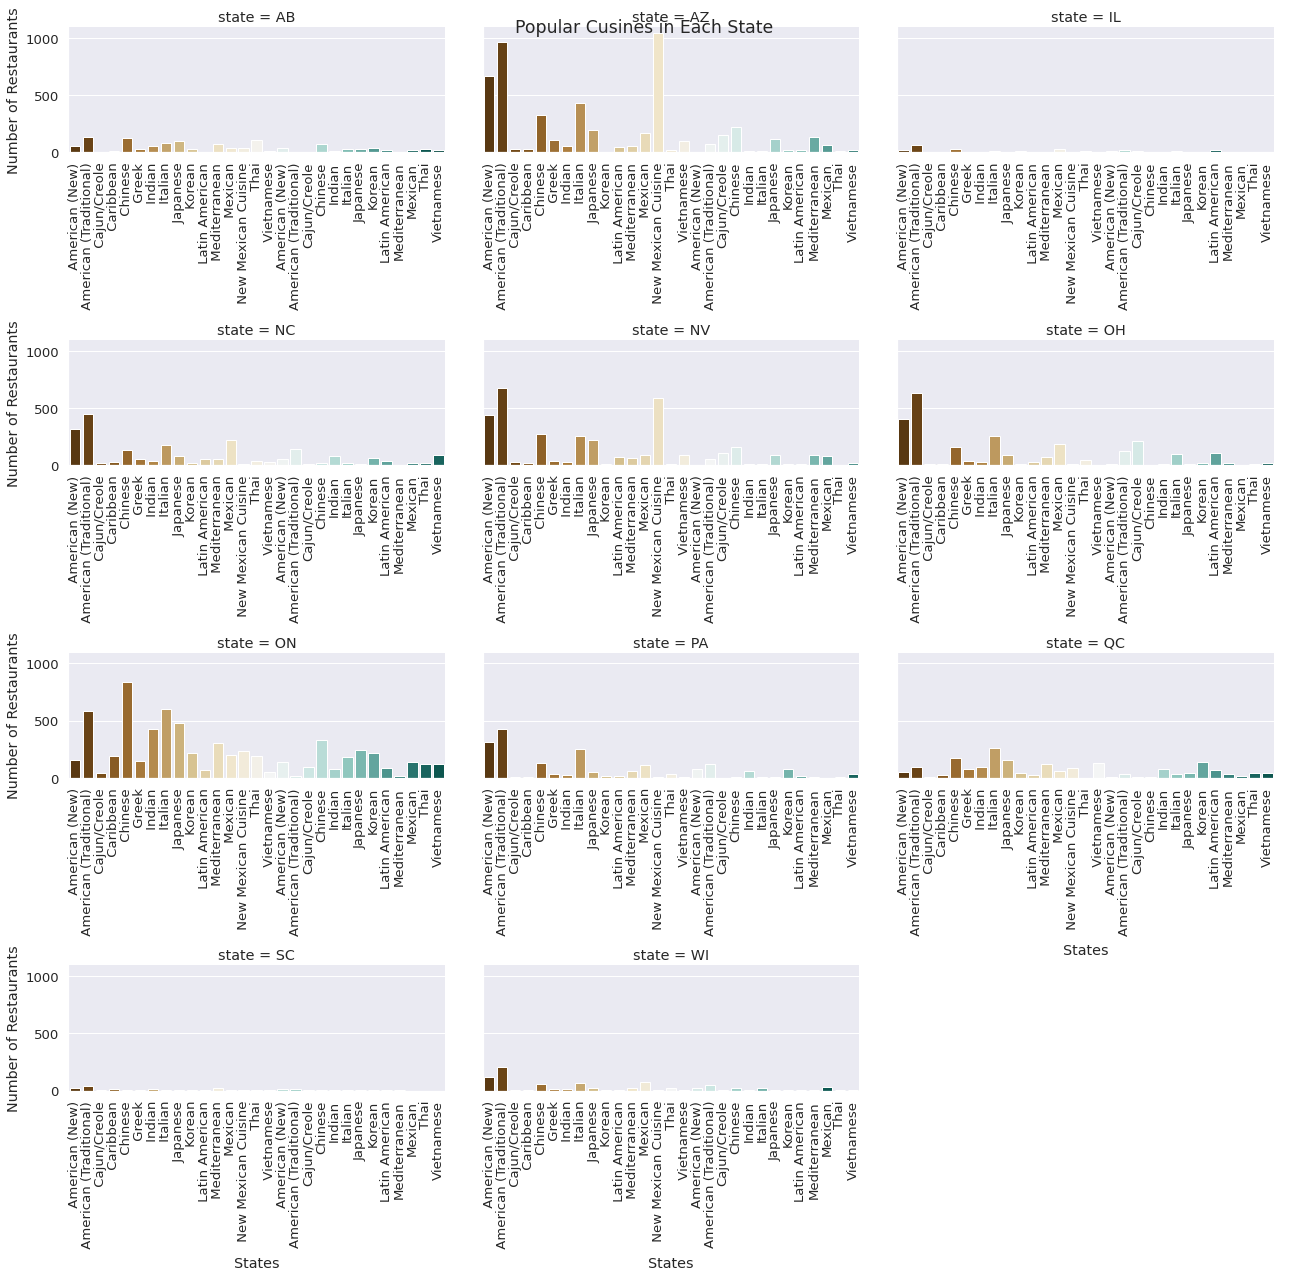

In [ ]:
sns.set_style("darkgrid", {'axes.grid': True})
sns.set_context("poster")
sns.set(font_scale = 1.2)


g = sns.FacetGrid(df_cusines_per_state, col='state', col_wrap=3,margin_titles=True, size=4,aspect=1.5)
g.map(sns.barplot,'categories','business_id',palette="BrBG")
g.add_legend()
g.set_xticklabels(rotation=90)
g.fig.suptitle('Popular Cusines in Each State')
plt.subplots_adjust(hspace=1.5, wspace=0.1)

for ax in g.axes.flatten():
    ax.tick_params(axis='x', labelrotation= 90 , labelbottom=True)
    
# g.set(xticks=[i for i in df_cusines_per_state.categories.unique()])
# plt.xticks(range(0,len(x_label)), x_label)

# Modify the details of the matplotlib Axes g
#g.despine(left=True)
g.set_ylabels('Number of Restaurants')
g.set_xlabels('States')
plt.show()

### Visualizing different restaurant type accross the states

In [ ]:
type_of_food_keywords = ['Fast Food', 'Cafe','Bar','Pub','Buffet', 'Vegetarian', 'Barbeque','Steakhouse','Salad', 'Sushi']

In [ ]:
df_type_of_food = get_restaurantdf(type_of_food_keywords, df_restaurant, pd.DataFrame(),'categories')
row_size = int(len(df_type_of_food)/14)
df_type_of_food = pd.DataFrame(df_type_of_food.values.reshape((row_size,14)), columns=df_restaurant.columns)

In [ ]:
df_food_explode_c = df_type_of_food.copy()
df_food_explode_c['categories'] = df_food_explode_c['categories'].apply(lambda x: x.split(','))
df_food_explode = df_food_explode_c.explode('categories')

In [ ]:
df_type_of_food_only= get_restaurantdf(type_of_food_keywords, df_food_explode, pd.DataFrame(),'categories')
row_size = int(len(df_type_of_food_only)/14)
df_type_of_food_only = pd.DataFrame(df_type_of_food_only.values.reshape((row_size,14)), columns=df_restaurant.columns)

In [ ]:
df_type_of_food_per_state = df_type_of_food_only.groupby(['state','categories']).count()['business_id'].reset_index()

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


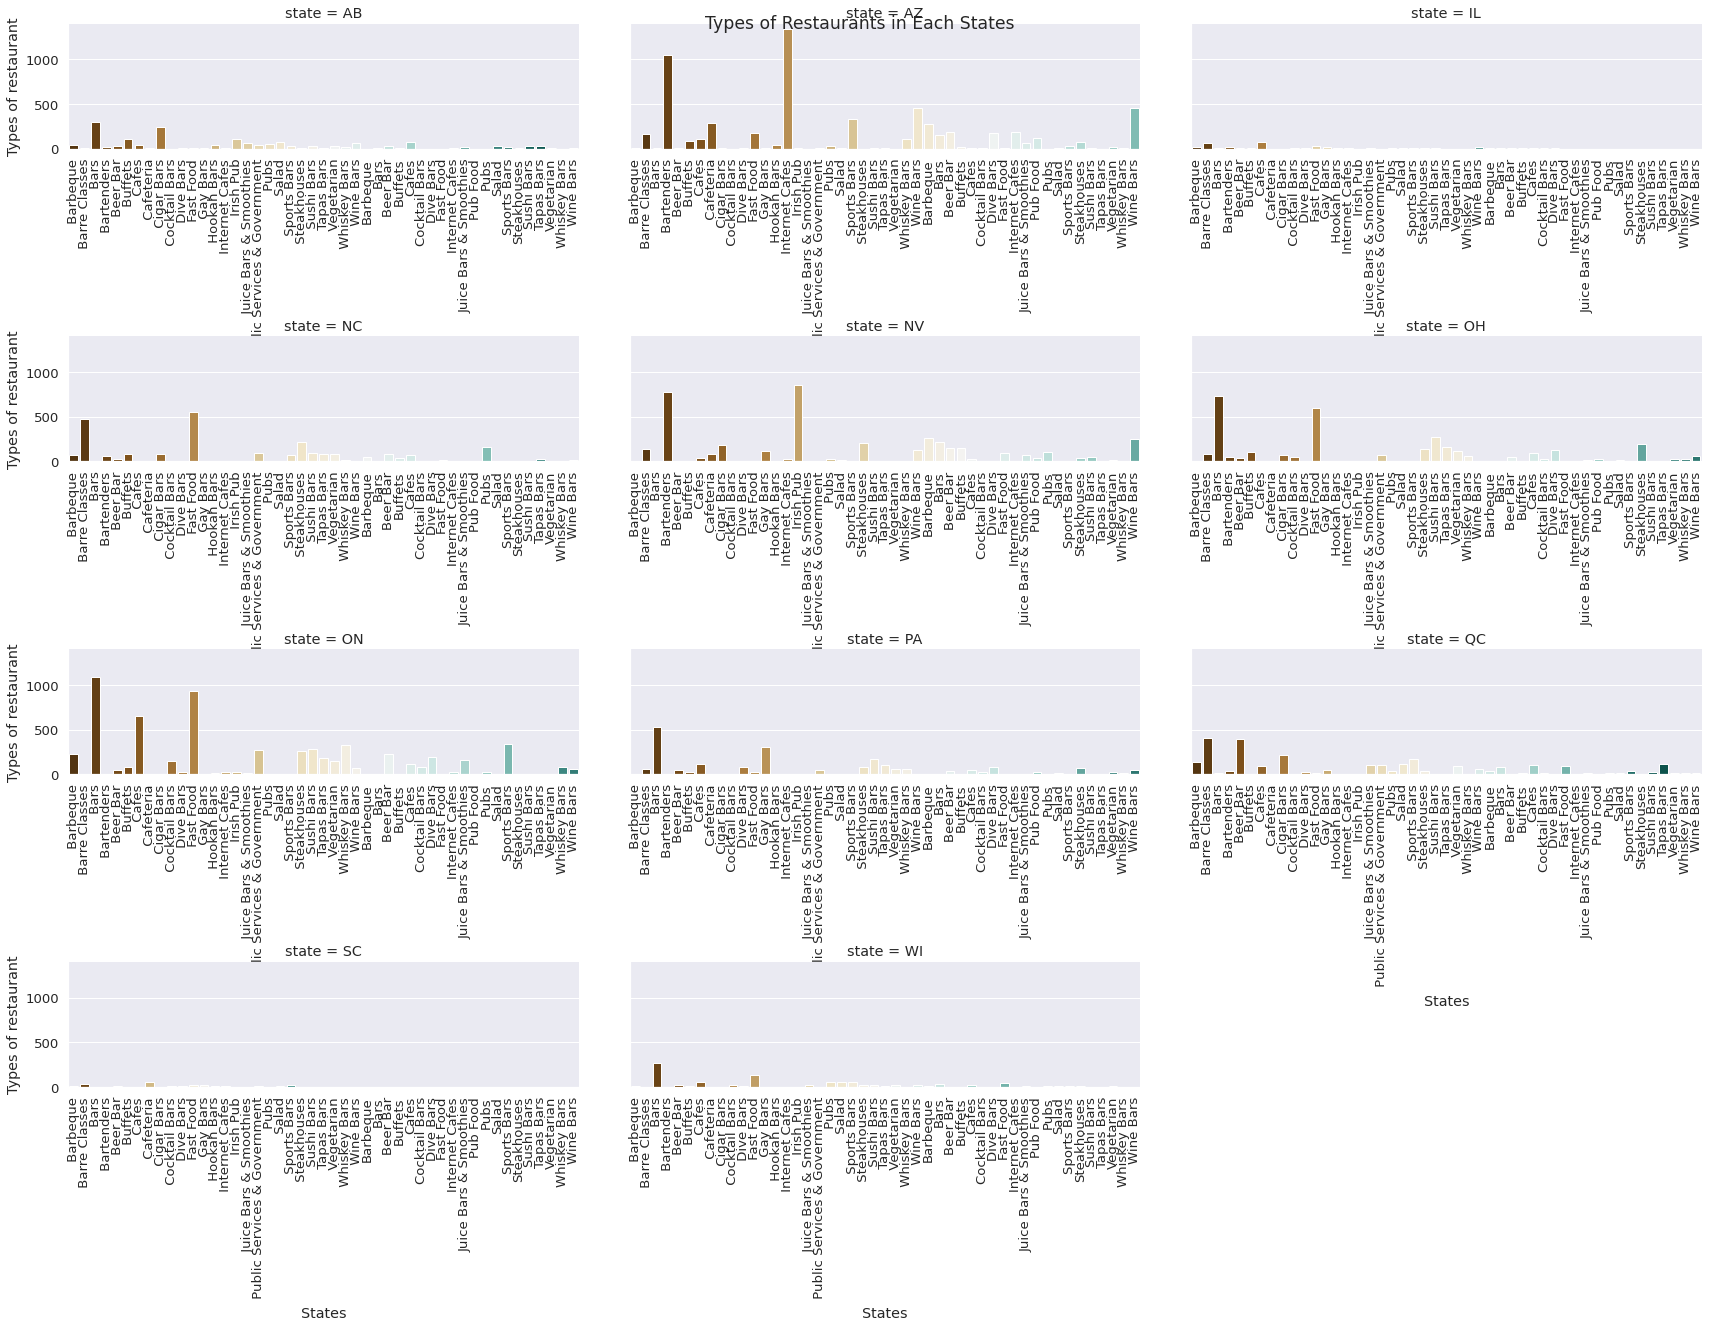

In [ ]:
sns.set_style("darkgrid", {'axes.grid': True})
sns.set_context("poster")
sns.set(font_scale = 1.2)


g = sns.FacetGrid(df_type_of_food_per_state , col='state', col_wrap=3,margin_titles=True, size=4,aspect=2)
g.map(sns.barplot,'categories','business_id',palette="BrBG")
g.add_legend()
g.set_xticklabels(rotation=90)
plt.subplots_adjust(hspace=1.5, wspace=0.1)
g.fig.suptitle('Types of Restaurants in Each States')

for ax in g.axes.flatten():
    ax.tick_params(axis='x', labelrotation= 90 , labelbottom=True)
    

g.set_ylabels('Types of restaurant')
g.set_xlabels('States')

In [ ]:
# df_type_of_food_per_state.to_pickle('/content/gdrive/MyDrive/YelpDataset/PickleFiles/df_type_of_food_per_state')
# del df_type_of_food_per_state

# Base Model 

Here we're using surprise package to build the base model. In this we are specifically using NormalPredictor model that predicts a random rating based on the distribution of the training set, which is assumed to be normal.

[Source Link](https://surprise.readthedocs.io/en/stable/basic_algorithms.html)

### Loading the data

**NOTE:**

Here we're only loading the data for state NC so that the reults are comparible whith the Neural Network model which also is trained on NC state data only.

In [ ]:
df_state= pd.read_pickle('/content/gdrive/MyDrive/YelpDataset/PickleFiles/yelp_data_df_NC')

In [ ]:
df_state.head()

,business_id,user_id,stars,text
16,oyjkEn5fAqcGNsBbqc8LTw,XivuRnPq3D-K5cPiBTztIA,1.0,good want several times hoping experience alwa...
41,gfhWUixZ4MmEAC1DtTsodA,iAQFEArbXp1WUrseOFTLMA,5.0,GREAT SERVICE food amazing reasonably priced O...
47,l_kefVF1frmC0xRW2YkvUA,oAFF_A02Ws0mwH-lkbzyMQ,2.0,Pros Fun atmosphere great people watching mech...
56,srHBs-NlG0upDlambkURbA,AVxQMKJsNvyNPbCJsinvYA,5.0,Fast friendly always make sure order correct e...
61,osSwv6CJy5hDKQdOKeyTow,XBRgHoPjOi4GgcYFCvYElQ,2.0,3 stars food service awful Appetizers ordered ...


In [ ]:
reader = Reader(rating_scale=(1, 5))

In [ ]:
data = Dataset.load_from_df(df_state[['user_id', 'business_id', 'stars']], reader) 

In [ ]:
# splitting the data into train and test set
train, test= train_test_split(data, train_size=0.8)

### Creating the base model

In [ ]:
np = NormalPredictor()
np.fit(train)

In [ ]:
np_predict_test = np.test(test)

### Result

In [ ]:
print('MSE of test data using baseline model = {:.2f}'.format(accuracy.mse(np_predict_test)))

MSE: 3.3062
MSE of test data using baseline model = 3.31


# Cosine Similarity model 

This model helps in finding the similar restaurants based on the cosine similarity between two restaurant vectors. 
Restaurant vector is built using the following features of restaurant column
-  business_id
-  attributes
-  categories

### Data Preparation

In [ ]:
business_df = pd.read_pickle('/content/gdrive/MyDrive/YelpDataset/PickleFiles/restuarant_df')
business_df.shape

(56901, 14)

In [ ]:
business_df = business_df.astype({'latitude':'float','longitude':'float','review_count':'int64','stars':'float'})

In [ ]:
business_df.dtypes

address          object
attributes       object
business_id      object
categories       object
city             object
hours            object
is_open          object
latitude        float64
longitude       float64
name             object
postal_code      object
review_count      int64
stars           float64
state            object
dtype: object

We are building a similarity matrix based on the columns Categories, Attributes, Stars and Review Count. The DataFrame in its current form has both the Caetegories and Attributes column in string formats, and we have to convert them to lists and dictionaries respectively.

We create additional columns with the modified versions of the Categories and Attributes

In [ ]:
# Removing None values
business_df['attributes'] = business_df['attributes'].fillna("{'None':'None'}") 

# Transforming the stringified dictionary to dictionary
business_df['attributes_edited'] = business_df['attributes'].apply(lambda x: literal_eval(x))

# Transforming the stringified list to list
business_df['categories_edited'] = business_df['categories'].apply(lambda x: x.split(',')) 

The updated attributes column still has dictionaries, so we transform the column to display the attributes in the format Attribute_Attribute value

In [ ]:
attribute_keys = []
for i in business_df['attributes_edited']: #We get the dictionary keys to find out how many unique attributes are there in the data
  attribute_keys.append(list(i.keys()))

attribute_keys = [item for sublist in attribute_keys for item in sublist]

unique_keys = list(set(attribute_keys))
print('Number of unique attributes in dataset:',len(unique_keys))

Number of unique attributes in dataset: 40


In [ ]:
# We write this function to separate out the keys(Attributes) and their values
def Attributes_Func(row): 
  xx = []
  for i in row.keys():
      xx.append(i+'_'+row[i])
  
  final_list = []
  for i in xx:
    if i.split('_')[1][0] == '{':
      continue
    else:
      final_list.append(i) 
  return(final_list)

In [ ]:
business_df['Attributes_List'] = business_df['attributes_edited'].apply(lambda x: Attributes_Func(x))

###  Building a Cosine Similarity Matrix

We only consider business_id, attribute_list and categories_edited columns for the Cosine Similarity calculations

In [ ]:
df_for_matrix = business_df[['business_id','Attributes_List','categories_edited']] #This is what our final DF for Count Vectorizer looks like
df_for_matrix.head()

,business_id,Attributes_List,categories_edited
0,pQeaRpvuhoEqudo3uymHIQ,"[RestaurantsAttire_u'casual', RestaurantsTakeO...","[Ethnic Food, Food Trucks, Specialty Food, ..."
1,M_guz7Dj7hX0evS672wIwA,"[BikeParking_True, Caters_True, WheelchairAcce...","[Desserts, Food, Ice Cream & Frozen Yogurt]"
2,mKTq1T_IAplDpHUcMzOXkw,[BusinessAcceptsCreditCards_True],"[Hotels & Travel, Transportation, Taxis, Be..."
3,eBEfgOPG7pvFhb2wcG9I7w,"[RestaurantsTableService_False, RestaurantsDel...","[Restaurants, Cheesesteaks, Poutineries]"
4,lu7vtrp_bE9PnxWfA8g4Pg,"[GoodForKids_True, RestaurantsTakeOut_True, Al...","[Japanese, Fast Food, Food Court, Restaurants]"


In [ ]:
# df_for_matrix.to_pickle('/content/drive/MyDrive/YelpDataset/PickleFiles/Attributes_and_Characteristics')
# del df_for_matrix

We clean the DataFrame so all entries in it are lower case, and we make transform each row corresponding to information about a restaurant to a string with each Category / Attribute_Attribute value separated out by spaces. This is done to be able to pass the rows into the CountVectorizer function

In [ ]:
# Function to convert all strings to lower case and strip names of spaces
#Code from Data Camp. Cleaning the text by converting to lower case
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [ ]:
features = ['business_id', 'Attributes_List', 'categories_edited']

for feature in features:
    df_for_matrix[feature] = df_for_matrix[feature].apply(clean_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
def create_soup(x): #We write this function to write the data as categories and attributes separated by spaces
    return(' '.join(x['Attributes_List']) + ' ' + ' '.join(x['categories_edited']) + ' ' + x['business_id'])

In [ ]:
df_for_matrix['soup'] = df_for_matrix.apply(create_soup, axis=1) #Joining values so it looks like next cell

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
# This is how our final data looks
df_for_matrix[['soup']].head(2).values 

array([["restaurantsattire_u'casual' restaurantstakeout_true businessacceptscreditcards_true noiselevel_u'quiet' goodforkids_false restaurantsreservations_false restaurantsgoodforgroups_false businessparking_none restaurantspricerange2_1 hastv_true alcohol_'none' bikeparking_false restaurantsdelivery_true byappointmentonly_false outdoorseating_false ethnicfood foodtrucks specialtyfood importedfood argentine food restaurants empanadas pqearpvuhoequdo3uymhiq"],
       ["bikeparking_true caters_true wheelchairaccessible_true restaurantspricerange2_1 wifi_u'no' businessacceptscreditcards_true restaurantstakeout_true desserts food icecream&frozenyogurt m_guz7dj7hx0evs672wiwa"]],
      dtype=object)

In [ ]:
# Creating Count Vectorizer matrix
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df_for_matrix['soup'])

In [ ]:
count_matrix.shape

(56901, 72150)


This count_matrix has transformed the text fields into a sparse matrix with 56901 rows -- corresponding to the number of restaurants in our data -- and 72150 columns -- corresponding to unique charateristics of each row

The technique we use for normalizing user ratings based on number of reviews is cooperated from the IMDB rating system. This is how it works:



```
WeightedRating (WR) = ((v/(v+m))*R) + ((m/v+m)*C)
```
Where
- v = rating count i.e total ratings that a restaurant has received
- m = minimum votes required to be listed as a truested restaurant
- R = average rating of the restaurant
- C = mean rating accross the whole dataset

[Source link](https://www.datacamp.com/community/tutorials/recommender-systems-python)



In [ ]:
stars_df = business_df[['review_count','stars']]

In [ ]:
c = stars_df['stars'].mean()
m = 50
# Function that computes the weighted rating of each restaurant
def weighted_rating(x, m=m, C=c):
    v = x['review_count']
    R = x['stars']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

stars_df['score'] = stars_df.apply(weighted_rating, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
# We add the weighted rating column to the vectorizer matrix
count_matrix = hstack([count_matrix,np.array(stars_df['score'])[:,None]]) 
count_matrix.shape

(56901, 72151)

In [ ]:
def cosine_similarity_n_space(m1, m2, batch_size=10):
    ret = np.ndarray((m1.shape[0], m2.shape[0]))
    for row_i in range(0, int(m1.shape[0] / batch_size) + 1):
        start = row_i * batch_size
        end = min([(row_i + 1) * batch_size, m1.shape[0]])
        if end <= start:
            break # cause I'm too lazy to elegantly handle edge cases
        rows = m1[start: end]
        sim = cosine_similarity(rows, m2) # rows is O(1) size
        ret[start: end] = sim
        del sim
    return ret

**WARNING:**

Running the below cell creates a 25 GB file which would restart the kernel.
We ran this on a local system to get the output 


In [ ]:
# cosine_sim2 = cosine_similarity_n_space(count_matrix, count_matrix)

The following function gets the top 20 similar restaurant based on the cosine similarity.

In [ ]:
top20_bid_dict = {}
indices = pd.Series(df_for_matrix.index, index=df_for_matrix['business_id']).drop_duplicates()

# Function to extract restaurant recommendations from Cosine Similarity matrix
def get_recommendations(title, cosine_sim): 
    # Get the index of the restaurant that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all restaurants with that restaurant
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 20 most similar restaurants
    sim_scores = sim_scores[1:21]

    # Get the restaurant indices
    restaurant_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar restaurants
    return df_for_matrix['business_id'].iloc[restaurant_indices]

### Getting the top 10 similar restaurants by adding the latitude and longitude information

The recommendation matrix that we have has all 56901 restaurants as row indices and their 20 most similar restaurants in the columns

We further consider the top 10 restaurants based on how close the restaurants are

In [ ]:
with open("/content/gdrive/MyDrive/YelpDataset/PickleFiles/restuarant_df", "rb") as fh:
  recommendations_df = pickle.load(fh)

In [ ]:
business_df_new = business_df.copy()
business_df_new['business_id'] = business_df_new['business_id'].apply(lambda x: x.lower())

We determine distance between 2 restaurants using their Latitudes and Longitudes based on the formula below and use that to recommend restaurants geographically closer to the target restaurant

In [ ]:
def distance_func(lat1,lon1,lat2,lon2): #Function to find distance between 2 coordinates
  R = 6373.0

  lat1 = radians(lat1)
  lon1 = radians(lon1)
  lat2 = radians(lat2)
  lon2 = radians(lon2)

  dlon = lon2 - lon1
  dlat = lat2 - lat1

  a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
  c = 2 * atan2(sqrt(a), sqrt(1 - a))

  distance = R * c
  return distance

In [ ]:
# This function calculates distance between a restaurant and all it's similars
def sort_list(ind): 
  distance = {}
  for bid in (recommendations_df.index[recommendations_df.index == ind]):
    sim_rest_dist = {}
    lat1 = business_df_new[business_df_new['business_id'] == bid]['latitude']
    lon1 = business_df_new[business_df_new['business_id'] == bid]['longitude']
    for sim_bid in recommendations_df.loc[bid]:
      lat2 = business_df_new[business_df_new['business_id'] == sim_bid]['latitude']
      lon2 = business_df_new[business_df_new['business_id'] == sim_bid]['longitude']
      dist = distance_func(lat1,lon1,lat2,lon2)
      sim_rest_dist[sim_bid] = dist
    distance[bid] = sim_rest_dist
    return distance

In [ ]:
def get_top10_similar_restaurants():
  counts = business_df['name'].value_counts()
  chains = counts.index[counts > 1]
  recommendations_final = pd.DataFrame()
  for i in recommendations_df.index: #Building a DataFrame for Top 10 recommendations for any given restaurant
    df = pd.DataFrame(sort_list(i)).sort_values(by = i)
    df = df.reset_index()
    df['index'] = df['index'].apply(lambda x: (business_df_new[business_df_new['business_id'] == x]['name'].iloc[0]+' - '+business_df_new[business_df_new['business_id'] == x]['city'].iloc[0]) if business_df_new[business_df_new['business_id'] == x]['name'].iloc[0] in chains else business_df_new[business_df_new['business_id'] == x]['name'].iloc[0])
    cols = df.columns
    df = df.drop([i],axis=1)
    if business_df_new[business_df_new['business_id'] == i]['name'].iloc[0] in chains:
      df.columns = [(business_df_new[business_df_new['business_id'] == i]['name'].iloc[0]+' - '+business_df_new[business_df_new['business_id'] == i]['city'].iloc[0])]
    else:
      df.columns = [business_df_new[business_df_new['business_id'] == i]['name'].iloc[0]]
    df = df.iloc[:10]
    recommendations_final[df.columns[0]] = df[df.columns[0]]

**WARNING**

Below code takes 2-3 hours to run. We have already calculated the top 10 restaurants and have saved in the pickle file with the name Recommendations_Final

In [ ]:
# get_top10_similar_restaurants
# recommendations_final.to_pickle('/content/drive/MyDrive/YelpDataset/PickleFiles/Recommendations_Final')

In [ ]:
recommendations_final = pd.read_pickle('/content/gdrive/MyDrive/YelpDataset/PickleFiles/Recommendations_Final')

def get_top10_recommendations(bname):
  return recommendations_final[bname]

In [ ]:
get_top10_recommendations('The Empanadas House')

0                            Ming Moon
1                        Hunan of Stow
2             China Dragon - Cleveland
3           Congin's Pizza - Cleveland
4    Salim's Middle Eastern Food Store
5                        Wok In Heaven
6                     Karachi kababeez
7     Chinese Food Gallery - Etobicoke
8                         Wok Terminal
9          Gardenia House Chinese Food
Name: The Empanadas House, dtype: object

Above you can see top 10 restaurants that are similar to 'The Empanadas House' based on the cusins and the services that the restaurants offer.

# Neural Network Model

Here we are combining the review and restaurant data (business data) and we are training our NN model to predict rating (stars) using Stochastic Gradient Decent.

We have tried to replicate the learnings from lab4.

### Data Preperation

**NOTE:**

Here we've trained the model only using the data of the state NC, since loading and traing the entire review dataset was crashing the kernel.

In [ ]:
# Restaurant df with attribute, title, categories
df_restaurant = pd.read_pickle('/content/gdrive/MyDrive/YelpDataset/PickleFiles/restaurants_with_title_attribute_category') 

In [ ]:
df_restaurant.head()

,business_id,Attributes_List,categories_edited,title
0,pQeaRpvuhoEqudo3uymHIQ,"[RestaurantsAttire_u'casual', RestaurantsTakeO...","[Ethnic Food, Food Trucks, Specialty Food, ...",The Empanadas House
1,M_guz7Dj7hX0evS672wIwA,"[BikeParking_True, Caters_True, WheelchairAcce...","[Desserts, Food, Ice Cream & Frozen Yogurt]",Chocolate Shoppe Ice Cream
2,mKTq1T_IAplDpHUcMzOXkw,[BusinessAcceptsCreditCards_True],"[Hotels & Travel, Transportation, Taxis, Be...",Tipsy Ryde
3,eBEfgOPG7pvFhb2wcG9I7w,"[RestaurantsTableService_False, RestaurantsDel...","[Restaurants, Cheesesteaks, Poutineries]",Philthy Phillys
4,lu7vtrp_bE9PnxWfA8g4Pg,"[GoodForKids_True, RestaurantsTakeOut_True, Al...","[Japanese, Fast Food, Food Court, Restaurants]",Banzai Sushi


In [ ]:
# loading reviews for the NC state
df_review = pd.read_pickle('/content/gdrive/MyDrive/YelpDataset/PickleFiles/reviews_of_NC_state') 

In [ ]:
df_review.head()

,business_id,date,stars,user_id
0,oyjkEn5fAqcGNsBbqc8LTw,2016-04-11 16:42:13,1.0,XivuRnPq3D-K5cPiBTztIA
1,gfhWUixZ4MmEAC1DtTsodA,2017-06-06 21:04:58,5.0,iAQFEArbXp1WUrseOFTLMA
2,l_kefVF1frmC0xRW2YkvUA,2018-01-21 04:58:46,2.0,oAFF_A02Ws0mwH-lkbzyMQ
3,srHBs-NlG0upDlambkURbA,2018-05-19 00:32:03,5.0,AVxQMKJsNvyNPbCJsinvYA
4,osSwv6CJy5hDKQdOKeyTow,2015-11-05 23:56:14,2.0,XBRgHoPjOi4GgcYFCvYElQ


To use embeddings, we must set up the index to be consecutive.

In [ ]:
users = df_review.user_id.unique()
restaurants = df_review.business_id.unique()

In [ ]:
#  all the users 0 indexed
restuarant_idx = {o:i for i,o in enumerate(restaurants)}
user_idx = {o:i for i,o in enumerate(users)}

In [ ]:
df_review['business_id'] = df_review.business_id.apply(lambda x: restuarant_idx[x]) 
df_review['user_id'] = df_review.user_id.apply(lambda x: user_idx[x]) 

In [ ]:
# getting all the restaurant info for the restuarants in the NC state
df_restaurant = df_restaurant[df_restaurant.business_id.isin(restaurants)]  

In [ ]:
# making a new column called ID which has the new final restaurant ID 
df_restaurant['id'] = df_restaurant.business_id.apply(lambda x: restuarant_idx[x]) 

In [ ]:
df_restaurant.head()

,business_id,Attributes_List,categories_edited,title,id
2,mKTq1T_IAplDpHUcMzOXkw,[BusinessAcceptsCreditCards_True],"[Hotels & Travel, Transportation, Taxis, Be...",Tipsy Ryde,354
34,3C0bnFhjkgYP9mWORKg6cA,"[RestaurantsTakeOut_True, RestaurantsDelivery_...","[Hot Dogs, Food, Street Vendors, Restaurants]",Chili Man,106
40,e1tqT4QNOUqDiOvmaIcxfQ,"[BusinessAcceptsCreditCards_True, DogsAllowed_...","[Active Life, Summer Camps, Personal Chefs, ...",Chef Alyssa's Kitchen,123
50,8k8cMmMcuj5h85mMLMoj2w,"[GoodForKids_True, WheelchairAccessible_True, ...","[Barbeque, Southern, Restaurants, American ...",RayNathan's,373
69,_V4CzzA7Z9h4qyLIdG-KUg,"[RestaurantsTakeOut_True, GoodForKids_True, Re...","[Restaurants, Hot Dogs, Burgers, Fast Food]",Wendy's,296


In [ ]:
# trasnformed key: restaurant_name
restaurant_names = df_restaurant.title.to_dict()

Saving the transformed file

In [ ]:
# df_review.to_csv("/content/gdrive/MyDrive/YelpDataset/CsvFiles/review_filtered_transformed_with_title.csv", index=False)
# df_restaurant.to_csv("/content/gdrive/MyDrive/YelpDataset/CsvFiles/restaurant_features_transformed_with_title.csv", index=False)
# del df_review
# del df_restaurant

**Train-test split**

In [ ]:
train_indices, val_indices = train_test_split(range(df_review.shape[0]), train_size=0.8, random_state=66, shuffle=True)
trdf = df_review.iloc[train_indices]
valdf = df_review.iloc[val_indices]
trdf.shape, valdf.shape

((253507, 4), (63377, 4))

### Building the Model

Setting hypeparameters, the size of the latent factors,  and the amount of regularization.

In [ ]:
L = 100
REG=5e-4

Funtion to create bias layer

In [ ]:
def create_bias(name, inp, n_in, reg):
    #x = Embedding(n_in, 1, input_length=1, embeddings_regularizer=l2(reg))(inp)
    x = Embedding(n_in, 1, input_length=1, name=name)(inp)
    return Flatten(name=name+'_flat')(x)

Function to create embedding layer

In [ ]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, name=name.split('_')[0]+'_factor', embeddings_regularizer=l2(reg))(inp)

Defining embeddings and biases

In [ ]:
nusers = df_review.user_id.nunique()
nrestaurants = df_review.business_id.nunique()
nusers, nrestaurants

(100965, 4386)

In [ ]:
user_input, uLmat = embedding_input('user_input', nusers, L, REG)
restuarant_input, mLmat = embedding_input('restaurant_input', nrestaurants, L, REG)

In [ ]:
user_bias = create_bias('user_bias', user_input, nusers, REG)
restaurant_bias = create_bias('restaurant_bias', restuarant_input, nrestaurants, REG)

The embeddings are matrix multiplied together to get the residual matrix, which is then flattened.

In [ ]:
residual = Dot(axes=2, name="residual")([uLmat, mLmat])
residflat = Flatten(name="residual_flat")(residual)

We add the flattened residual and the biases into the linear regression, since we're trying to predict the rating a user might give to a particular restaurant

In [ ]:
regression = Add(name="regression")([user_bias, restaurant_bias, residflat]) 

Function for calculating custom sigmoid value that ranges from 0-5.5

In [ ]:
def sigmoid_maker(low, high):
    def custom_sigmoid(x):
        return K.sigmoid(x)*(high - low) + low #within range
    return custom_sigmoid

In [ ]:
cs = sigmoid_maker(0, 5.5)

In [ ]:
output = Activation(cs, name="Sigmoid_Range")(regression)

Now we set up the model with the user_ids and restaurant_ids as input, and the output of the sigmoid as output.
We further compile it with Adam optimizer and a learning rate of 0.001.
Finally we get the summary of the model.

In [ ]:
model = Model([user_input, restuarant_input], output)
model.compile(Adam(0.001), loss='mse')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
restaurant_input (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_factor (Embedding)         (None, 1, 100)       10096500    user_input[0][0]                 
__________________________________________________________________________________________________
restaurant_factor (Embedding)   (None, 1, 100)       438600      restaurant_input[0][0]           
______________________________________________________________________________________________

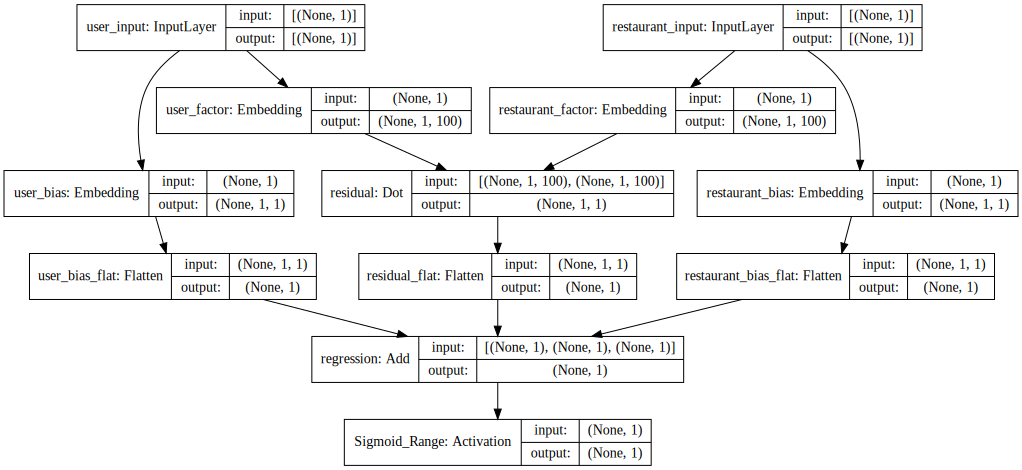

In [ ]:
import pydot
from tensorflow.keras.utils import model_to_dot

from IPython.display import SVG
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, dpi=72, rankdir='TB').create_svg())

### Training the model

In [ ]:
model.optimizer.lr = 0.001 

**NOTE:**

The following cell takes ~8mins per epoch with runtime as GPU. We've already trained the model and saved it in cf.h5 file. 

In [ ]:
# Load the trained model 
new_model = tf.keras.models.load_model('cf.h5')

In [ ]:
X = trdf.drop(['stars','date'], axis=1)
y = trdf['stars']
X_val = valdf.drop(['stars','date'], axis=1)
y_val = valdf['stars']
history_1 = model.fit([trdf['user_id'], trdf['business_id']],y, validation_data=([valdf['user_id'], valdf['business_id']], y_val), epochs=10)

Epoch 1/10
7923/7923 [==============================] - 533s 67ms/step - loss: 2.5004 - val_loss: 1.7576
Epoch 2/10
7923/7923 [==============================] - 527s 66ms/step - loss: 1.6123 - val_loss: 1.5917
Epoch 3/10
7923/7923 [==============================] - 526s 66ms/step - loss: 1.4309 - val_loss: 1.5414
Epoch 4/10
7923/7923 [==============================] - 525s 66ms/step - loss: 1.3449 - val_loss: 1.5202
Epoch 5/10
7923/7923 [==============================] - 522s 66ms/step - loss: 1.2880 - val_loss: 1.5107
Epoch 6/10
7923/7923 [==============================] - 522s 66ms/step - loss: 1.2329 - val_loss: 1.5072
Epoch 7/10
7923/7923 [==============================] - 524s 66ms/step - loss: 1.1895 - val_loss: 1.5059
Epoch 8/10
7923/7923 [==============================] - 523s 66ms/step - loss: 1.1565 - val_loss: 1.5070
Epoch 9/10
7923/7923 [==============================] - 527s 66ms/step - loss: 1.1266 - val_loss: 1.5099
Epoch 10/10
7923/7923 [==============================] 

In [ ]:
#Saving the model

# model.save_weights("/content/gdrive/MyDrive/cf.h5")

### Plotting the train and validation loss

In [ ]:
def plot_loss(history):  
  #your code here 
  plt.rcParams["figure.figsize"] = (10,8)
  plt.title("Batch normalized model")
  plt.semilogy(history.history['loss'], label='Train Loss', color='#FF9A98', linewidth=1)
  plt.semilogy(history.history['val_loss'],  label='Validation Loss', color='#75B594', linewidth=2)
  plt.legend()

  # Set the axes labels
  plt.xlabel('Epochs')
  plt.ylabel('MSE Loss')
  plt.tight_layout()
  plt.legend()
  plt.show()

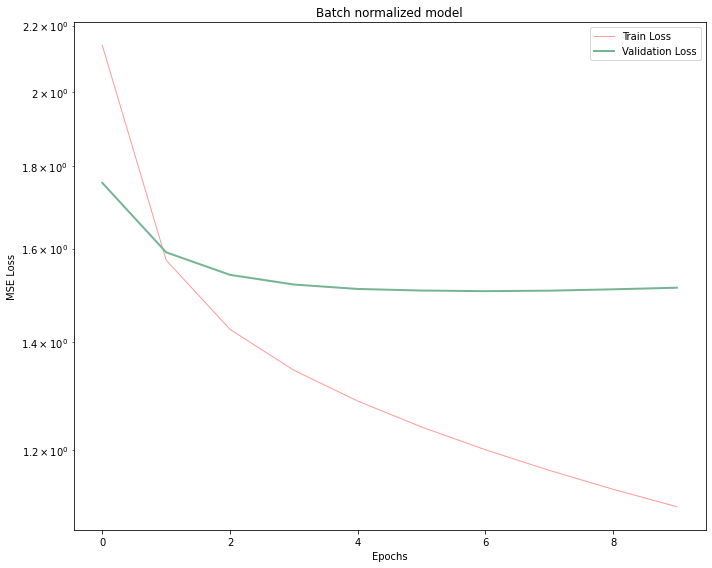

In [ ]:
plot_loss(history_1)

Here we can see that the validation loss is increasing after 9 epochs, and the difference between train and validation loss is also huge, so if we train the model further, it would overfit.

# NLP model

Here we further tried to improve the model by using the customer's review text and building a NLP model on top of that, but unfortunately couldn't arraive at conclusive results due to lack in computation power.

Approach:

- We loaded the review data for state NC, cleaned the text by removing stopwords and lowercasing the sentences. 
- Created user dataframe by combining all the reviews that the user has given to a restaurant 
- Created business dataframe by combining all the reviews that the restaurant has received by a user
- We've created the userid_vector and businessid_vector by calculating the TF-IDF score of the top 5000 words.
- We are further doing the matrix factorization that takes in userid_vector, business_id vector and the rating matrix, performs Stochastic Gradient Descent and returns the optimal userid_vector and business_id vector. 
- Now the user can type in the query like "provide me the restaurants with a good ambience", it would return the top restaurants that satisties the above query.



Kindly refer [this notebook](https://github.com/Manisha2297/RestroRecommender/blob/main/Notebooks/NLTKmodel.ipynb) to get the overview of the work that we did. Running the entire code here will take hours together, so have performed most of the text processing in chunks and have saved the dataframe after every step. 

# Conclusion and future work 
We  started  with  cosine  similarity  model  which helps  in finding  similar  restaurants  based  on restaurant’s  features,  but  this  doesn’t  take customer preference into consideration. So, to    better    understand    the    customer preferences,   we   created   a   Neural   Network model  by  using customer  review  data  which outperformedthe  base  line  model  in  terms  of MSE.

**Future Work**: We can improve the recommendation system by suggesting restaurant  that  follow COVIDsafety  protocols and  personalize  the  model  further  by  making use of the user details data.